In [ ]:
from google.colab import drive
drive.mount('/content/drive')




import os
import shutil
import re
import numpy as np
from scipy import interpolate
import pandas as pd
#import tensorflow_decision_forests as tfdf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import tree
from glob import glob
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

path="/content/drive/MyDrive/merge"


# z-변환 함수 정의
def z_normalize(data):
    return (data - np.mean(data)) / np.std(data)


# Gravity DNN 모델
def create_gravity_model(input_shape):
    input_gravity = Input(shape=input_shape)
    x=layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_gravity)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    return models.Model(inputs=input_gravity, outputs=x)

def create_accelerometer_model(input_shape):
    input_acc = Input(shape=input_shape)
    x=layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_acc)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    return models.Model(inputs=input_acc, outputs=x)

# Gyroscope DNN 모델
def create_gyroscope_model(input_shape):
    input_gyro = Input(shape=input_shape)
    x=layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_gyro)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    return models.Model(inputs=input_gyro, outputs=x)

# Magnetic DNN 모델
def create_magnetic_model(input_shape):
    input_magnetic = Input(shape=input_shape)
    x=layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_magnetic)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x=layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x=layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    return models.Model(inputs=input_magnetic, outputs=x)



df=pd.DataFrame()
mode=pd.DataFrame()
for sample_files in os.listdir(path):

    sample_file=pd.read_csv(path+"//"+sample_files)

    #X=sample_file.iloc[:,:-2]
    # y=sample_file[['Mode', 'Survay1']]
    sample_mode_file=sample_file[['Mode']]
    # sample_mode_file=pd.get_dummies(sample_mode_file,columns=["Mode"])
    col_names=sample_file.iloc[:,1:-2].columns

    sample_file=sample_file.iloc[:,:-2]

    # 각 센서 데이터에 대해 z-변환 적용
    sample_file = sample_file.apply(z_normalize)

    col_names=sample_file.columns
    df=pd.concat([df,sample_file],axis=0,ignore_index=True)
    mode=pd.concat([mode,sample_mode_file],
                      axis=0,ignore_index=True)



#z_normalization
df = df.apply(z_normalize)



df_columns=df.columns
ori_Gra_df=pd.DataFrame()
ori_LAcc_df=pd.DataFrame()
ori_Gyro_df=pd.DataFrame()
ori_Mag_df=pd.DataFrame()

ori_Gra_df=df.iloc[:,:3]
ori_LAcc_df=df.iloc[:,3:6]
ori_Gyro_df=df.iloc[:,6:9]
ori_Mag_df=df.iloc[:,9:]




ori_Gra_df=ori_Gra_df.values
ori_LAcc_df=ori_LAcc_df.values
ori_Gyro_df=ori_Gyro_df.values
ori_Mag_df=ori_Mag_df.values



lst=[15,30 ,60,120,180,240,300]

for i in lst:
    df_mode=pd.DataFrame()
   # for j in range(i,mode.shape[0]+1,i):
 #       df_mode=pd.concat([df_mode,mode[j-1:j]],ignore_index=True)
    Gra_df=ori_Gra_df
    LAcc_df=ori_LAcc_df
    Gyro_df=ori_Gyro_df
    Mag_df=ori_Mag_df



    df_mode = mode.iloc[::i].reset_index(drop=True)
    Gra_df=np.reshape(Gra_df, (-1, i, 3))
    LAcc_df=np.reshape(LAcc_df, (-1, i, 3))
    Gyro_df=np.reshape(Gyro_df, (-1, i, 3))
    Mag_df=np.reshape(Mag_df, (-1, i, 3))








# 결과 확인
# X=df
    y=df_mode
    y=pd.get_dummies(y,columns=["Mode"])

    epochs=30
    learning_rates=0.001
    batch_size=128

#데이터 분할

    Gra_df_train,Gra_df_test=train_test_split(Gra_df,test_size=0.3,random_state=42)
    LAcc_df_train,LAcc_df_test=train_test_split(LAcc_df,test_size=0.3,random_state=42)
    Gyro_df_train,Gyro_df_test=train_test_split(Gyro_df,test_size=0.3,random_state=42)
    Mag_df_train,Mag_df_test=train_test_split(Mag_df,test_size=0.3,random_state=42)


    #데이터 분할
# X_train,X_test=train_test_split(X,test_size=0.3,random_state=42)
    y_train,y_test=train_test_split(y,test_size=0.3,random_state=42)



# 라벨을 one-hot 인코딩
#train_labels = to_categorical(y_train)
#test_labels = to_categorical(y_test)
#

# 2. DNN 모델 구축

    gravity_model = create_gravity_model((i,3))
    accelerometer_model = create_accelerometer_model((i,3))
    gyroscope_model = create_gyroscope_model((i,3))
    magnetic_model = create_magnetic_model((i,3))




# 각 모델의 출력을 병합 (Concatenate)
    combined = layers.concatenate([
        gravity_model.output,
        accelerometer_model.output,
        gyroscope_model.output,
        magnetic_model.output

    ])



# 병합된 출력을 DNN에 통합
    x = layers.Dense(256, activation='relu')(combined)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(7, activation='softmax')(x)  # 예: 10개의 클래스를 예측하는 모델

# 최종 통합 모델 생성
    final_model = models.Model(inputs=[gravity_model.input,accelerometer_model.input, gyroscope_model.input, magnetic_model.input], outputs=output)

# 모델 컴파일
    final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



    final_model.fit([Gra_df_train,LAcc_df_train,Gyro_df_train,Mag_df_train ], y_train, epochs=epochs, batch_size=batch_size)
# 5. 테스트 데이터로 성능 평가
    test_loss, test_acc = final_model.evaluate([Gra_df_test,LAcc_df_test,Gyro_df_test,Mag_df_test ], y_test)
    print(f"{i/60}s 의 Test accuracy: {test_acc}")





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.7493 - loss: 0.6624
Epoch 2/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.9084 - loss: 0.2669
Epoch 3/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9300 - loss: 0.2049
Epoch 4/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9398 - loss: 0.1755
Epoch 5/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9471 - loss: 0.1557
Epoch 6/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9513 - loss: 0.1425
Epoch 7/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9548 - loss: 0.1321
Epoch 8/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9571 - loss: 0.1250
Epoch 9/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9595 - loss: 0.1183
Epoch 10/30
10474/10474 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms

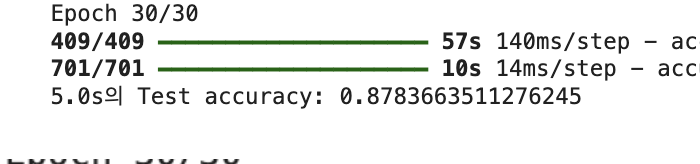

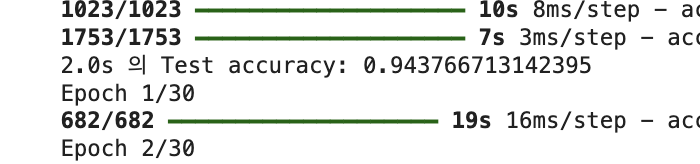

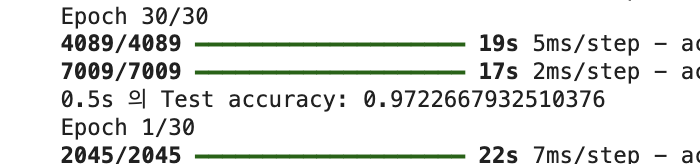

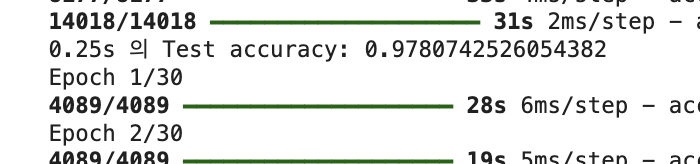

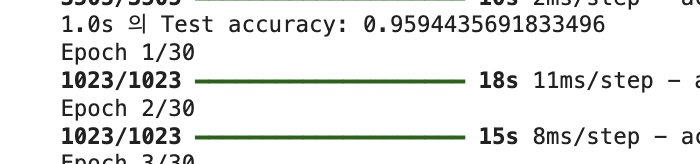

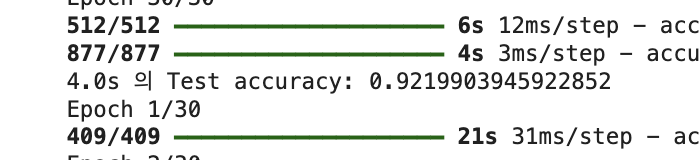

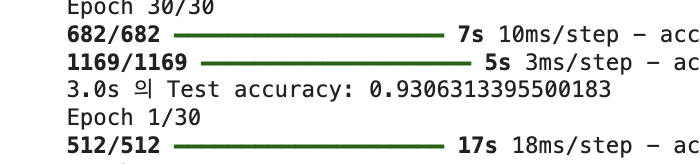